# 실습 1: ResNet-18 파인튜닝 심화 (초중급)

## 학습 목표
- ResNet-18 사전 학습 모델 활용
- **학습률 스케줄러** 적용하여 성능 개선
- **Early Stopping**으로 과적합 방지
- 학습 곡선 시각화 및 분석
- 혼동 행렬(Confusion Matrix)로 모델 성능 상세 분석

---

In [ ]:
# 필수 라이브러리 임포트
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR, ReduceLROnPlateau
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from tqdm import tqdm
import time
import copy

# 한글 폰트 설정 (Colab)
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['axes.unicode_minus'] = False

# 재현성을 위한 시드 고정
def set_seed(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

# GPU 사용 가능 여부 확인
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'사용 디바이스: {device}')
if torch.cuda.is_available():
    print(f'GPU 이름: {torch.cuda.get_device_name(0)}')

## 2. 데이터 로드 및 전처리

**데이터 증강 기법:**
- `RandomHorizontalFlip`: 좌우 반전
- `RandomCrop`: 랜덤 자르기
- `ColorJitter`: 밝기, 대비, 채도 조정
- `Normalize`: ImageNet 평균과 표준편차로 정규화

In [ ]:
# 데이터 변환 정의
def get_transforms():
  # 훈련 데이터 변환(데이터 증강)
  train_transform = transforms.Compose([
      transforms.Resize(128), # 크기 고정
      transforms.RandomCrop(112),
      transforms.RandomHorizontalFlip(p=0.5), # 50% 확률로 좌우 반전
      transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2), # 색상변환

      transforms.ToTensor(),
      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

  ])
  # 검증 데이터 변환(증강 없어야 함)
  val_transform = transforms.Compose([
      transforms.Resize(112), # 크기 고정 (가로 세로 비율 유지) Resize((112,112))
      # transforms.CenterCrop(112) : 중앙에 위치 112*112 로 잘라서 만들어줘 (정보손실 가능)

      transforms.ToTensor(),
      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

  ])

  return train_transform, val_transform

In [ ]:
# CIFAR-10 데이터셋 로드
def load_data(batch_size=64):
    train_transform, val_transform = get_transforms()

    # 훈련 데이터
    train_dataset = torchvision.datasets.CIFAR10(
        root='./data',
        train=True,
        download=True,
        transform=train_transform
    )

    # 검증 데이터
    val_dataset = torchvision.datasets.CIFAR10(
        root='./data',
        train=False,
        download=True,
        transform=val_transform
    )

    # 데이터 로더 생성
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=2,
        pin_memory=True  # GPU 전송 속도 향상
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=2,
        pin_memory=True
    )

    return train_loader, val_loader

# 데이터 로드
train_loader, val_loader = load_data(batch_size=64)

# 클래스 이름
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

print(f'훈련 데이터: {len(train_loader.dataset)}개')
print(f'검증 데이터: {len(val_loader.dataset)}개')
print(f'배치 크기: {train_loader.batch_size}')



모델 생성 및 수정

In [ ]:
# 원래 resnet은 imagenet 에 사용된 사전학습된 가중치임
# 이 모델은 1000개 클래스로 분류하는 분류기를 사용함
# 마지막 FC layer(분류기)를 cifar-10의 10개 클래스에 맞게 교체 작업할 것임

def create_model(num_classes=10, pretrained=True):
    model = models.resnet18(weights='IMAGENET1K_V1' if pretrained else None)

    # 마지막 FC (분류기) 입력 차원 확인
    num_features = model.fc.in_features
    print(num_features)

    # 새로운 FC(내 분류기)로 교체 (10개 클래스)
    model.fc = nn.Linear(num_features, num_classes)
    print(model.fc)

    # 모델을 gpu로 이동
    model = model.to(device)

    return model


# 모델 생성
model = create_model(num_classes=10, pretrained=True)

# 모델 파라미터(학습 대상) 수 확인
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'모델 파라미터 수: {total_params:,}')
print(f'학습 가능한 파라미터 수: {trainable_params:,}')

학습 설정

In [ ]:
# 학습 설정 함수
def setup_training(model, lr=0.001, momentum=0.9, num_epochs=20):
  # 손실함수
  criterion = nn.CrossEntropyLoss()

  # 최적화 함수 (SGD with Momentun)
  optimizer = optim.SGD(model.parameters(), lr=lr,
                        momentum=momentum, weight_decay=1e-4) # L2정규화
  # 학습률 스케쥴러(CosineAnnealingLR) : 학습률을 코사인처럼 부드럽게 감소
  # >> 처음에 천천히 감소, 학습 중반에 빠르게 감소, 후반에 매우 천천히
  # T_max: 학습률이 최소값에 도달하는 에폭 수
  scheduler = CosineAnnealingLR(optimizer,
                                T_max=num_epochs,
                                eta_min=1e-6) # 최소학습률

  return criterion, optimizer, scheduler

In [ ]:
num_epochs = 20
criterion, optimizer, scheduler = setup_training(model, lr=0.001, num_epochs=num_epochs)

print(f'학습한 횟수(epochs): {num_epochs}')
print(f'초기 학습률: {optimizer.param_groups[0]['lr']}')

Early Stopping 구현

In [ ]:
# Early Stopping 클래스
class EarlyStopping:
    def __init__(self, patience=5, delta=0.0, path='best_model.pth'):
        """
        Args:
            patience (int): 개선이 없어도 기다리는 에폭 수
            delta (float): 개선으로 간주하는 최소 변화량
            path (str): 최적 모델 저장 경로
        """
        self.patience = patience
        self.delta = delta
        self.path = path
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.inf

    def __call__(self, val_loss, model):
        score = -val_loss

        if self.best_score is None:
            # 첫 번째 에폭
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            # 개선이 없는 경우
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} / {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            # 개선된 경우
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        """검증 손실이 감소하면 모델 저장"""
        print(f'검증 손실 감소 ({self.val_loss_min:.6f} --> {val_loss:.6f}). 모델 저장...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

# Early Stopping 객체 생성
early_stopping = EarlyStopping(patience=5, delta=0.001, path='resnet18_best.pth')
print('Early Stopping 설정 완료')

학습 검증 함수

- 모델을 훈련 모드로 설정
- 미니배치 마다 순전차 >> 손실 계산 >> 역전파 >> 파라미터 업데이트
- 에폭마다 검증 데이터(평가용 데이터) 성능 평가
- 학습률 스켈쥴러로 학습률 조정

In [ ]:
# 훈련 함수
def train_one_epoch(model, train_loader, criterion, optimizer, device):
  model.train() # 훈련모드로 설정

  running_loss = 0
  correct = 0
  total = 0

  #tqdm 진행상태 표시할게요
  pbar = tqdm(train_loader, desc="Training...")
  for inputs, labels in pbar:
    inputs, labels = inputs.to(device), labels.to(device)

    # 경사 초기화
    optimizer.zero_grad()

    # 순전파(모델 예측) >> 손실계산
    outputs = model(inputs)
    loss = criterion(outputs, labels)

    # 역전파 및 최적화
    loss.backward()
    optimizer.step()

    # 통계 계산
    running_loss += loss.item() * inputs.size(0)
    _, predicted = torch.max(outputs, 1)

    total += labels.size(0)
    correct += (predicted == labels).sum().item()

    # 진행상태 업데이트
    pbar.set_postfix({'loss': loss.item(), 'acc': 100 * correct / total})

  epoch_loss = running_loss / total
  epoch_acc = 100 * correct / total

  return epoch_loss, epoch_acc

In [ ]:
# 검증 함수
def validate(model, val_loader, criterion, device):
  model.eval() # 평가모드로 전환

  running_loss = 0
  correct = 0
  total = 0

  with torch.no_grad():
    pbar = tqdm(val_loader, desc="Validation")
    for inputs, labels in pbar:
            inputs, labels = inputs.to(device), labels.to(device)

            # 순전파
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # 통계 계산
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            pbar.set_postfix({'loss': loss.item(), 'acc': 100 * correct / total})

  epoch_loss = running_loss / total
  epoch_acc = 100 * correct / total

  return epoch_loss, epoch_acc


전체 학습 실행

In [ ]:
# 학습 히스토리 저장
history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': [],
    'lr': []
}

# 학습 시작
start_time = time.time()

for epoch in range(num_epochs):
    print(f'[{epoch+1}/{num_epochs}]')

    # 현재 학습률 출력
    current_lr = optimizer.param_groups[0]['lr']
    print(current_lr)

    # 훈련
    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)

    # 검증
    val_loss, val_acc = validate(model, val_loader, criterion, device)

    # 학습률 스케쥴러 업데이트
    scheduler.step()

    # 히스토리 저장
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    history['lr'].append(current_lr)

    # 결과 출력
    print(f'\n훈련 손실: {train_loss:.4f}, 훈련 정확도: {train_acc:.2f}%')
    print(f'검증 손실: {val_loss:.4f}, 검증 정확도: {val_acc:.2f}%')

    # 조기 종료 확인
    early_stopping(val_loss, model)
    if early_stopping.early_stop:
        print("Early stopping")
        break

# 학습 종료
elapsed_time = time.time() - start_time # 경과 시간
print(f"학습 완료하는 데 걸린 총 소요시간: {elapsed_time/60:.2f}분")

#최적 모델 로드
model.load_state_dict(torch.load('resnet18_best.pth'))

학습 결과 시각화

In [ ]:
# 학습 곡선 시각화
def plot_history(history):
    epochs = range(1, len(history['train_loss']) + 1)

    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    # 손실 곡선
    axes[0].plot(epochs, history['train_loss'], 'b-o', label='Train Loss', linewidth=2)
    axes[0].plot(epochs, history['val_loss'], 'r-s', label='Val Loss', linewidth=2)
    axes[0].set_xlabel('Epoch', fontsize=12)
    axes[0].set_ylabel('Loss', fontsize=12)
    axes[0].set_title('Loss Curve', fontsize=14, fontweight='bold')
    axes[0].legend(fontsize=10)
    axes[0].grid(True, alpha=0.3)

    # 정확도 곡선
    axes[1].plot(epochs, history['train_acc'], 'b-o', label='Train Acc', linewidth=2)
    axes[1].plot(epochs, history['val_acc'], 'r-s', label='Val Acc', linewidth=2)
    axes[1].set_xlabel('Epoch', fontsize=12)
    axes[1].set_ylabel('Accuracy (%)', fontsize=12)
    axes[1].set_title('Accuracy Curve', fontsize=14, fontweight='bold')
    axes[1].legend(fontsize=10)
    axes[1].grid(True, alpha=0.3)

    # 학습률 변화
    axes[2].plot(epochs, history['lr'], 'g-^', linewidth=2)
    axes[2].set_xlabel('Epoch', fontsize=12)
    axes[2].set_ylabel('Learning Rate', fontsize=12)
    axes[2].set_title('Learning Rate Schedule', fontsize=14, fontweight='bold')
    axes[2].grid(True, alpha=0.3)
    axes[2].set_yscale('log')  # 로그 스케일

    plt.tight_layout()
    plt.show()

    # 최종 결과 출력
    print('=' * 60)
    print('최종 학습 결과')
    print('=' * 60)
    print(f'최종 훈련 손실: {history["train_loss"][-1]:.4f}')
    print(f'최종 훈련 정확도: {history["train_acc"][-1]:.2f}%')
    print(f'최종 검증 손실: {history["val_loss"][-1]:.4f}')
    print(f'최종 검증 정확도: {history["val_acc"][-1]:.2f}%')
    print(f'최고 검증 정확도: {max(history["val_acc"]):.2f}%')
    print('=' * 60)

# 시각화 실행
plot_history(history)

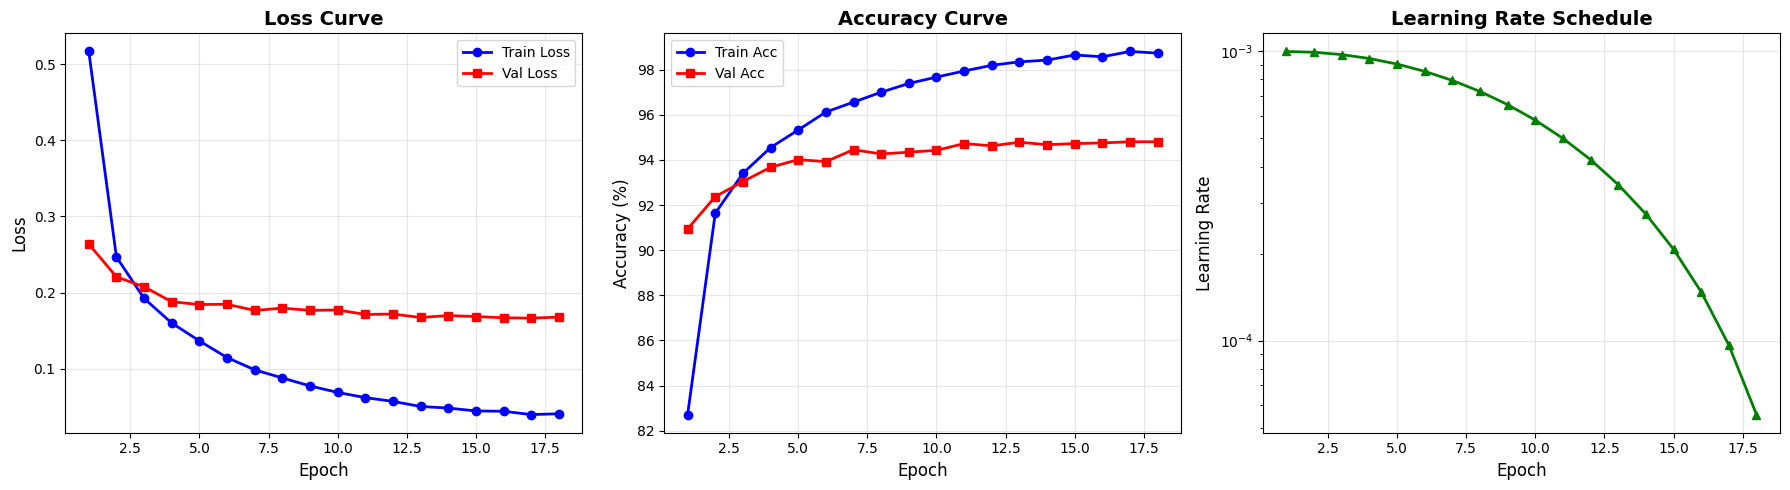

혼동 행렬

In [ ]:
# 혼동 행렬 생성 함수
def get_predictions(model, loader, device):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in tqdm(loader, desc='Predicting'):
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.numpy())

    return np.array(all_preds), np.array(all_labels)

# 혼동 행렬 시각화 함수
def plot_confusion_matrix(y_true, y_pred, class_names):
    # 혼동 행렬 계산
    cm = confusion_matrix(y_true, y_pred)

    # 시각화
    plt.figure(figsize=(12, 10))
    sns.heatmap(
        cm,
        annot=True,
        fmt='d',
        cmap='Blues',
        xticklabels=class_names,
        yticklabels=class_names,
        cbar_kws={'label': 'Count'}
    )
    plt.xlabel('Predicted Label', fontsize=12, fontweight='bold')
    plt.ylabel('True Label', fontsize=12, fontweight='bold')
    plt.title('Confusion Matrix', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

    # 클래스별 정확도 계산
    class_accuracy = cm.diagonal() / cm.sum(axis=1) * 100

    print('\n클래스별 정확도:')
    print('=' * 40)
    for i, (name, acc) in enumerate(zip(class_names, class_accuracy)):
        print(f'{name:12s}: {acc:6.2f}%')
    print('=' * 40)

# 예측 및 시각화
y_pred, y_true = get_predictions(model, val_loader, device)
plot_confusion_matrix(y_true, y_pred, class_names)

# 분류 리포트 출력
print('\n\n상세 분류 리포트:')
print('=' * 60)
print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

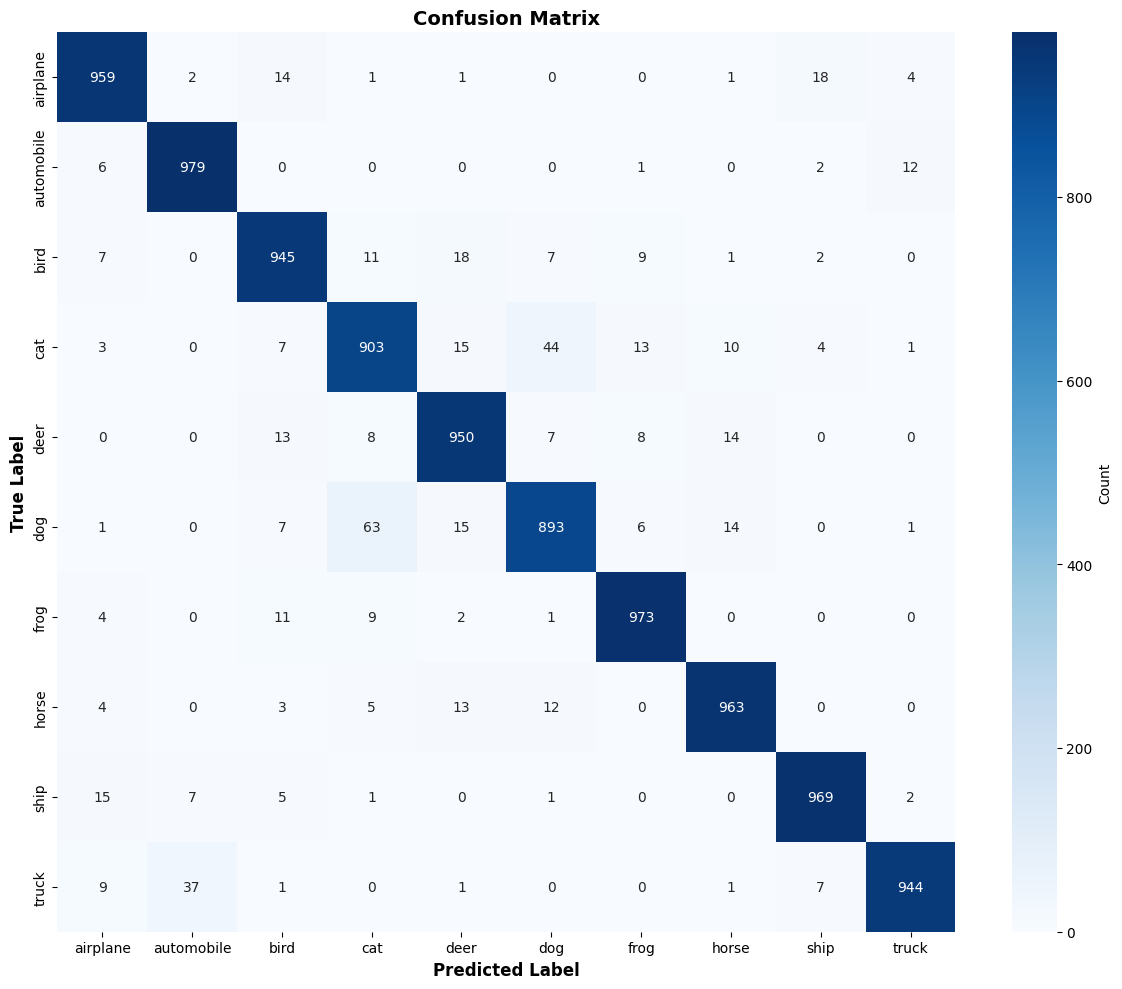

샘플 예측 시각화

In [ ]:
# 샘플 예측 시각화
def visualize_predictions(model, loader, class_names, device, num_images=16):
    model.eval()

    # 데이터 가져오기
    dataiter = iter(loader)
    images, labels = next(dataiter)
    images = images[:num_images]
    labels = labels[:num_images]

    # 예측
    with torch.no_grad():
        outputs = model(images.to(device))
        _, predicted = torch.max(outputs, 1)
        predicted = predicted.cpu()

    # 이미지 역정규화
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    images = images * std + mean
    images = torch.clamp(images, 0, 1)

    # 시각화
    fig, axes = plt.subplots(4, 4, figsize=(12, 12))
    axes = axes.ravel()

    for idx in range(num_images):
        img = images[idx].permute(1, 2, 0).numpy()
        true_label = class_names[labels[idx]]
        pred_label = class_names[predicted[idx]]

        # 올바른 예측은 파란색, 잘못된 예측은 빨간색
        color = 'blue' if labels[idx] == predicted[idx] else 'red'

        axes[idx].imshow(img)
        axes[idx].set_title(
            f'True: {true_label}\nPred: {pred_label}',
            color=color,
            fontsize=10,
            fontweight='bold'
        )
        axes[idx].axis('off')

    plt.tight_layout()
    plt.show()

# 샘플 예측 시각화 실행
visualize_predictions(model, val_loader, class_names, device, num_images=16)

주요 기법 정리

1. 사전 학습 모델 활용
- 전이학습 (미리 학습이 되어 있는 좋은 모델 사용 >> 학습 시간 단축)

2. 학습률 스케쥴러 (CosineAnnealingLR)
- 코사인 함수 형태, 학습률을 부드럽게 감소
- 학습 초반 : 큰 학습률 >> 빠르게 수렴됨
- 학습 후반 : 작은 학습률 >> 세밀한 조정

3. 조기종료(Early Stopping)
- 검증 손실(val_loss) 더 이상 개선되지 않으면 학습 조기 종료
- 과적합 방지(학습 시간 절약)

4. 데이터 증강
- 모델의 일반화 성능 향상
- RandomHorizontalFlip, RandomCrop